# Библиотеки

In [1]:
import neptune
import cv
import model_selection
import nn_model
import nn_training
import preprocessing
import optuna
import numpy as np
import re
from sklearn.metrics import mean_squared_error
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
rcParams['figure.figsize'] = 20, 10

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
neptune.init('iliaavilov/Magnit-test')

Project(iliaavilov/Magnit-test)

# Константы

In [4]:
random_state = 54321
data_path = 'data/'

# Загрузка данных

In [5]:
data = pd.read_csv('{}data_regression_for_task.csv'.format(data_path))

Сразу отложим тестовую часть датасета

In [6]:
data_test = data[(data['YEAR'] == 2018) & (data['MONTH'] == 2)].copy()

# EDA

In [7]:
data.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0


In [8]:
data = data.sort_values(['YEAR', 'MONTH']).reset_index(drop = True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 0 to 128354
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           128355 non-null  int64  
 1   MONTH          128355 non-null  int64  
 2   CONTRAGENT     128331 non-null  object 
 3   ARTICLE_CODE   128355 non-null  object 
 4   ARTICLE_NAME   128355 non-null  object 
 5   ARTICLE_GROUP  128354 non-null  object 
 6   SALES          128355 non-null  float64
 7   STORE_SALES    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


In [10]:
data[['YEAR', 'MONTH']].drop_duplicates()

,YEAR,MONTH
0,2017,4
5195,2017,5
18648,2017,6
32276,2017,8
45866,2017,9
59252,2017,10
72878,2017,11
87410,2017,12
101910,2018,1
115255,2018,2


In [11]:
for col in ['CONTRAGENT', 'ARTICLE_CODE', 'ARTICLE_NAME', 'ARTICLE_GROUP']:
    print('Уникальных значений в колонке {}'.format(col), len(data[col].unique()))

Уникальных значений в колонке CONTRAGENT 334
Уникальных значений в колонке ARTICLE_CODE 23556
Уникальных значений в колонке ARTICLE_NAME 23624
Уникальных значений в колонке ARTICLE_GROUP 9


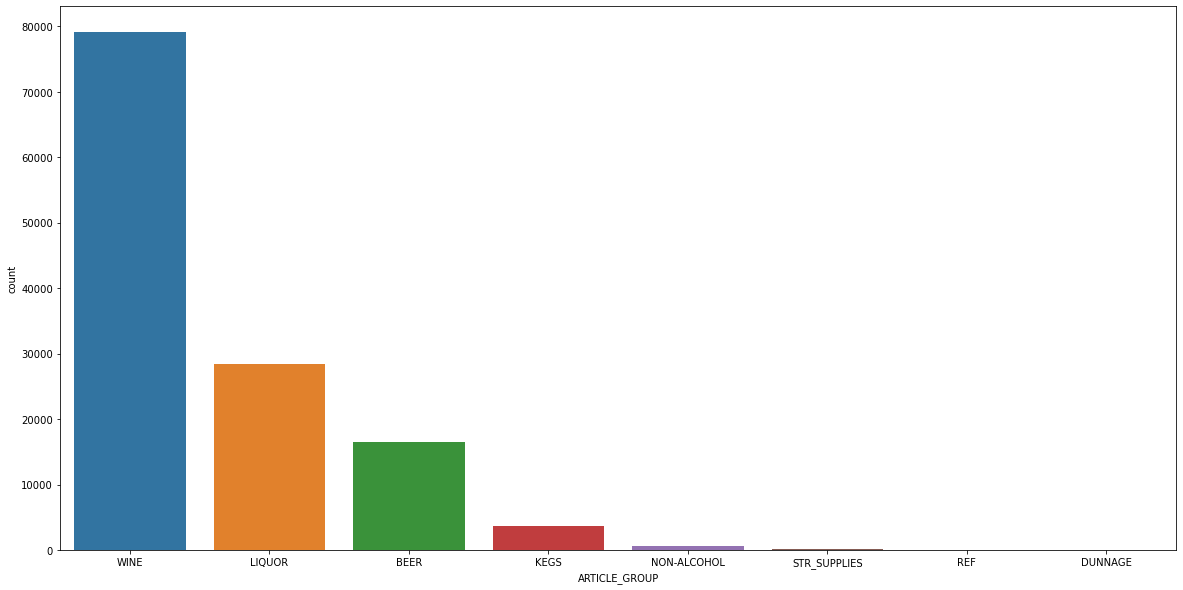

In [12]:
_ = sns.countplot(data['ARTICLE_GROUP'], order = data['ARTICLE_GROUP'].value_counts().index)

ARTICLE_GROUP = DUNNAGE - это пустые кеги. Продажи (SALES) всегда 0

In [13]:
data[data['ARTICLE_GROUP'] == 'DUNNAGE']

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
19477,2017,6,NaN,1279,EMPTY WINE KEG - KEGS,DUNNAGE,0.0,-9.0
19857,2017,6,ANHEUSER BUSCH INC,175,EMPTY 1/2 KEG (30.00),DUNNAGE,0.0,-4804.0
20094,2017,6,ANHEUSER BUSCH INC,205,EMPTY 1/6 KEG (30.00),DUNNAGE,0.0,-1208.0
21120,2017,6,ANHEUSER BUSCH INC,264,EMPTY 1/4 KEG (30.00),DUNNAGE,0.0,-363.0
32277,2017,8,NaN,1279,EMPTY WINE KEG - KEGS,DUNNAGE,0.0,-5.0
33429,2017,8,ANHEUSER BUSCH INC,175,EMPTY 1/2 KEG (30.00),DUNNAGE,0.0,-4536.0
33690,2017,8,ANHEUSER BUSCH INC,205,EMPTY 1/6 KEG (30.00),DUNNAGE,0.0,-1068.0
34760,2017,8,ANHEUSER BUSCH INC,264,EMPTY 1/4 KEG (30.00),DUNNAGE,0.0,-331.0
46512,2017,9,NaN,1279,EMPTY WINE KEG - KEGS,DUNNAGE,0.0,-9.0
46998,2017,9,ANHEUSER BUSCH INC,175,EMPTY 1/2 KEG (30.00),DUNNAGE,0.0,-4210.0


ARTICLE_GROUP = DUNNAGE - это судя по всему товары, изготавливаемые самим  магазином (Магазинное вино, аэратор, открывашка для бутылок)\
BEER CREDIT, WINE CREDIT - продажи всегда 0

In [14]:
data[data['ARTICLE_GROUP'] == 'REF']

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
111,2017,4,Default,112,CORKSCREW,REF,0.0,0.0
18988,2017,6,Default,112,CORKSCREW,REF,20400.0,0.0
28624,2017,6,Default,59668,STORE SPECIAL WINE 355 ML - 355ML,REF,8550.0,0.0
28626,2017,6,Default,59781,STORE SPECIAL WINE 750 ML - 750ML,REF,1650.0,0.0
32274,2017,6,NaN,BC,BEER CREDIT,REF,0.0,-58.0
32275,2017,6,NaN,WC,WINE CREDIT,REF,0.0,-8.0
32570,2017,8,Default,112,CORKSCREW,REF,19300.0,0.0
33159,2017,8,Default,140,WINE AERATOR-IN BOTTLE,REF,160.0,0.0
42280,2017,8,Default,59781,STORE SPECIAL WINE 750 ML - 750ML,REF,80.0,0.0
45864,2017,8,NaN,BC,BEER CREDIT,REF,0.0,-699.0


ARTICLE_GROUP = STR_SUPPLIES - подарочные упаковки под бутылки

In [15]:
data[data['ARTICLE_GROUP'] == 'STR_SUPPLIES'].sort_values('SALES')

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
24,2017,4,Default,104,FOUR BOTTLE WINE TOTE,STR_SUPPLIES,0.0,0.0
85714,2017,11,KAHN PAPER COMPANY INC,8044,BAGS - PAPER PINTS,STR_SUPPLIES,0.0,0.0
85681,2017,11,KAHN PAPER COMPANY INC,8036,BAGS - PAPER 12LB,STR_SUPPLIES,0.0,0.0
85651,2017,11,KAHN PAPER COMPANY INC,8028,BAGS - PAPER 20LB,STR_SUPPLIES,0.0,0.0
85583,2017,11,KAHN PAPER COMPANY INC,8010,BAGS - PAPER QUARTS,STR_SUPPLIES,0.0,0.0
...,...,...,...,...,...,...,...,...
87524,2017,12,Default,105,WINE GIFT TOTE SINGLE BOTTLE,STR_SUPPLIES,59500.0,0.0
46202,2017,9,Default,114,WINE PAPER GIFT TOTE SINGLE BOTTLE,STR_SUPPLIES,60440.0,0.0
73217,2017,11,Default,114,WINE PAPER GIFT TOTE SINGLE BOTTLE,STR_SUPPLIES,64760.0,0.0
19049,2017,6,Default,114,WINE PAPER GIFT TOTE SINGLE BOTTLE,STR_SUPPLIES,77520.0,0.0


Из названия остальных групп понятен их смысл

Найдем такие товары, продажи которых всегда 0

In [16]:
zero_sales = data.groupby('ARTICLE_NAME').filter(lambda x: x['SALES'].sum() == 0)

In [17]:
len(zero_sales['ARTICLE_NAME'].unique())

11677

Таких товаров 11677 из всех 23624. При обучении модели попробуем давать ей только данные о ненулевых продажах.

Продажи товаров уже сгруппированы по месяцам

In [18]:
data[data[['YEAR', 'MONTH', 'ARTICLE_CODE']].duplicated()]

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES


Количество товаров по месяцам то растет, то падает, поэтому в текущем месяце может продаваться товар, который не продавался в предыдущие месяцы. Поэтому при обучении не будем использовать артикль и полное название товара (модель переобучится + не сможет предсказывать продажи для новых товаров)

In [19]:
data.groupby(['YEAR', 'MONTH']).size()

YEAR  MONTH
2017  4         5195
      5        13453
      6        13628
      8        13590
      9        13386
      10       13626
      11       14532
      12       14500
2018  1        13345
      2        13100
dtype: int64

В названии товара есть информация об объеме (если это напиток). Извлечем ее с помощью регулярных выражений

In [20]:
def find_volume(x):
    # Находим в строке подстроки вида '700ML', '12OZ' и тд
    list_of_matches = re.findall(r'\d+\.?\d*\s?(?:(?:OZ|Z)|ML|L)', x)
    
    # Если нашлась такая подстрока, то извлекаем число и конвертируем в милилитры
    if len(list_of_matches)>0:
        if ('L' in list_of_matches[0]) and ('ML' not in list_of_matches[0]):
            return float(re.findall(r'\d+\.?\d*', list_of_matches[0])[0])*1000
        if 'ML' in list_of_matches[0]:
            return float(re.findall(r'\d+\.?\d*', list_of_matches[0])[0])
        if ('OZ' in list_of_matches[0]) or ('Z' in list_of_matches[0]):
            return float(re.findall(r'\d+\.?\d*', list_of_matches[0])[0])*29.5735
    
data['VOLUME'] = data['ARTICLE_NAME'].apply(find_volume)
data_test['VOLUME'] = data_test['ARTICLE_NAME'].apply(find_volume)

Удалось извлечь информацию об объеме почти для всех товаров

In [21]:
data['VOLUME'].isnull().sum()

6907

In [22]:
data.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,VOLUME
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0,750.0
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0,375.0
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0,375.0
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0,1750.0
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0,750.0


Создаем колонку с информацией о дате

In [23]:
data['DATE'] = pd.to_datetime(data[['YEAR', 'MONTH']].assign(DAY=1))
data_test['DATE'] = pd.to_datetime(data_test[['YEAR', 'MONTH']].assign(DAY=1))

In [24]:
summed_sales = data.groupby(['DATE', 'ARTICLE_GROUP'], as_index = False)['SALES'].sum()

In [25]:
summed_sales.head(50)

,DATE,ARTICLE_GROUP,SALES
0,2017-04-01,BEER,0.0
1,2017-04-01,LIQUOR,0.0
2,2017-04-01,NON-ALCOHOL,0.0
3,2017-04-01,REF,0.0
4,2017-04-01,STR_SUPPLIES,0.0
5,2017-04-01,WINE,0.0
6,2017-05-01,BEER,25023240.0
7,2017-05-01,LIQUOR,35123360.0
8,2017-05-01,WINE,34546890.0
9,2017-06-01,BEER,27863260.0


В первый месяц продажи во всех группах нулевые\
Также нет информации о продажах в группах NON-ALCOHOL, REF и STR_SUPPLIES в первые два месяцы.
Удалим только первый  месяц, чтобы не терять информацию о продажах в других группах во втором месяце

In [26]:
data = data[data['DATE'] != pd.to_datetime('2017-04-01')]

В группах 'DUNNAGE', 'KEGS' продажи всегда нулевые, удалим эти группы

In [27]:
data[data['ARTICLE_GROUP'].isin(['DUNNAGE', 'KEGS'])]['SALES'].sum()

0.0

In [28]:
data = data[data['ARTICLE_GROUP'].isin(['DUNNAGE', 'KEGS']) == False]

In [29]:
summed_sales = data.groupby(['DATE', 'ARTICLE_GROUP'], as_index = False)['SALES'].sum()

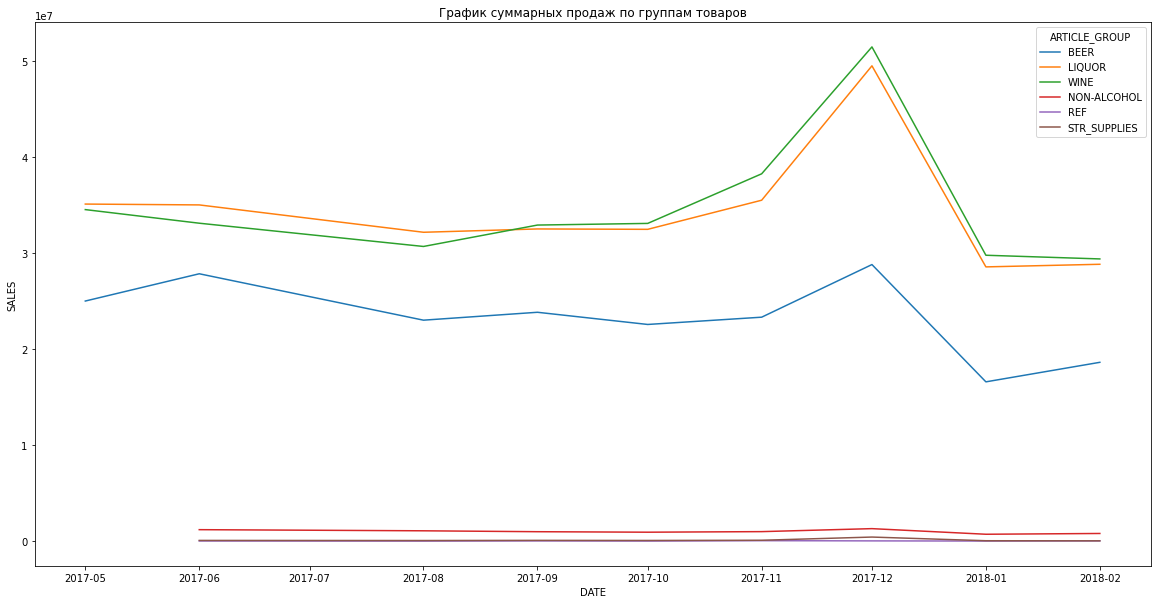

In [30]:
_ = sns.lineplot(x = 'DATE', 
                 y = 'SALES', 
                 hue = 'ARTICLE_GROUP', 
                 data = summed_sales)
_ = plt.title('График суммарных продаж по группам товаров')

In [31]:
mean_sales = data.groupby(['DATE', 'ARTICLE_GROUP'], as_index = False)['SALES'].mean()

In [32]:
mean_sales.head()

,DATE,ARTICLE_GROUP,SALES
0,2017-05-01,BEER,14455.944541
1,2017-05-01,LIQUOR,12136.613683
2,2017-05-01,WINE,3913.331445
3,2017-06-01,BEER,15831.397727
4,2017-06-01,LIQUOR,11937.073254


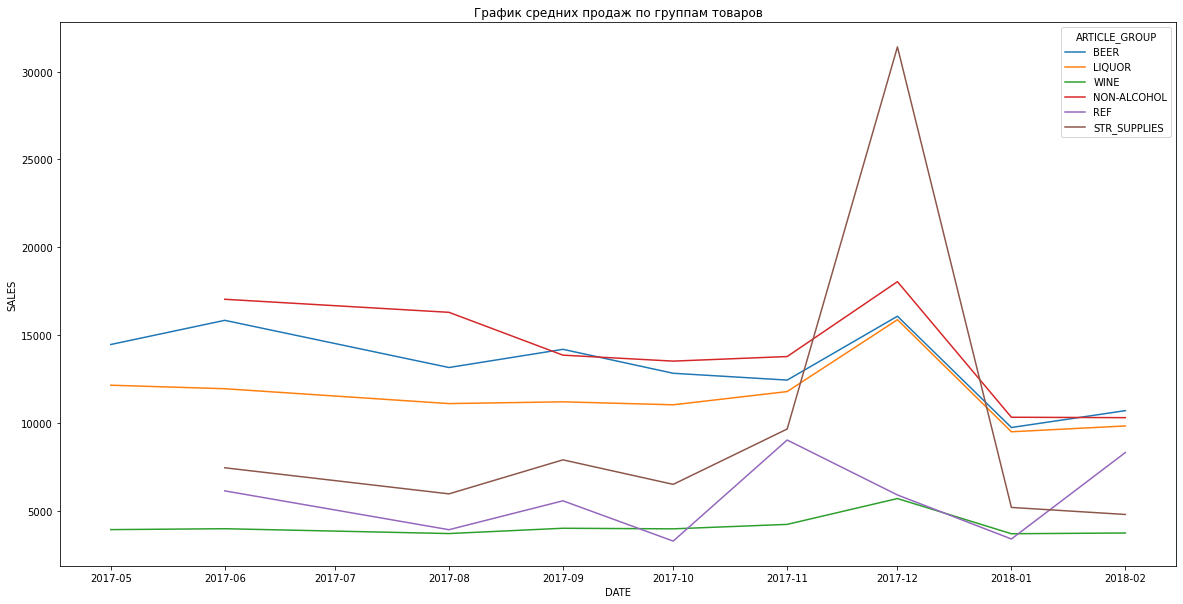

In [33]:
_ = sns.lineplot(x = 'DATE', 
                 y = 'SALES', 
                 hue = 'ARTICLE_GROUP', 
                 data = mean_sales)
_ = plt.title('График средних продаж по группам товаров')

Видно, что в новый год сильно подскачили не только суммарные продажи, но также и средние продажи. То есть рост продаж произошел не только за счет увеличение ассортимента. Т.к. данные доступны за период меньше года и такая аномалия произошла только в одном месяце, то удалим этот месяц. Если оставить этот месяц, то не получится построить адекватную модель. Подбирая гиперпараметры на валидации (в которую войдет этот месяц) придется выбирать такие параметры, которые будут завышать прогноз модели (чтобы предсказания на этом месяце не были слишком далеки от реально). При этом на тестовой части (ПРЕДПОСЛЕДНИЙ МЕСЯЦ, А НЕ ПОСЛЕДНИЙ. ПОСЛЕДНИЙ - true test, то есть по честному мы его вообще не видим) продажи наоборот падают).

In [34]:
data = data[data['DATE'] != pd.to_datetime('2017-12-01')]

Распределение таргета

In [35]:
data.sort_values(['SALES'], ascending = False).head(50)

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,VOLUME,DATE
20654,2017,6,CROWN IMPORTS,23445,CORONA EXTRA LOOSE NR - 12OZ,BEER,1249000.0,13723.71,354.8820,2017-06-01
32121,2017,6,CROWN IMPORTS,96741,CORONA EXTRA 4/6 NR - 12OZ,BEER,1138360.0,7210.92,354.8820,2017-06-01
69105,2017,10,FIFTH GENERATION INC,53929,TITO'S HANDMADE VODKA - 1.75L,LIQUOR,1101390.0,19.00,1750.0000,2017-10-01
28437,2017,6,FIFTH GENERATION INC,53929,TITO'S HANDMADE VODKA - 1.75L,LIQUOR,1080890.0,15.00,1750.0000,2017-06-01
55459,2017,9,FIFTH GENERATION INC,53929,TITO'S HANDMADE VODKA - 1.75L,LIQUOR,1065280.0,15.00,1750.0000,2017-09-01
47872,2017,9,CROWN IMPORTS,23445,CORONA EXTRA LOOSE NR - 12OZ,BEER,1063000.0,12733.83,354.8820,2017-09-01
18529,2017,5,CROWN IMPORTS,96741,CORONA EXTRA 4/6 NR - 12OZ,BEER,1037370.0,7283.96,354.8820,2017-05-01
74904,2017,11,CROWN IMPORTS,23445,CORONA EXTRA LOOSE NR - 12OZ,BEER,992000.0,16079.12,354.8820,2017-11-01
34308,2017,8,CROWN IMPORTS,23445,CORONA EXTRA LOOSE NR - 12OZ,BEER,990000.0,15346.71,354.8820,2017-08-01
124541,2018,2,FIFTH GENERATION INC,53929,TITO'S HANDMADE VODKA - 1.75L,LIQUOR,983020.0,18.00,1750.0000,2018-02-01


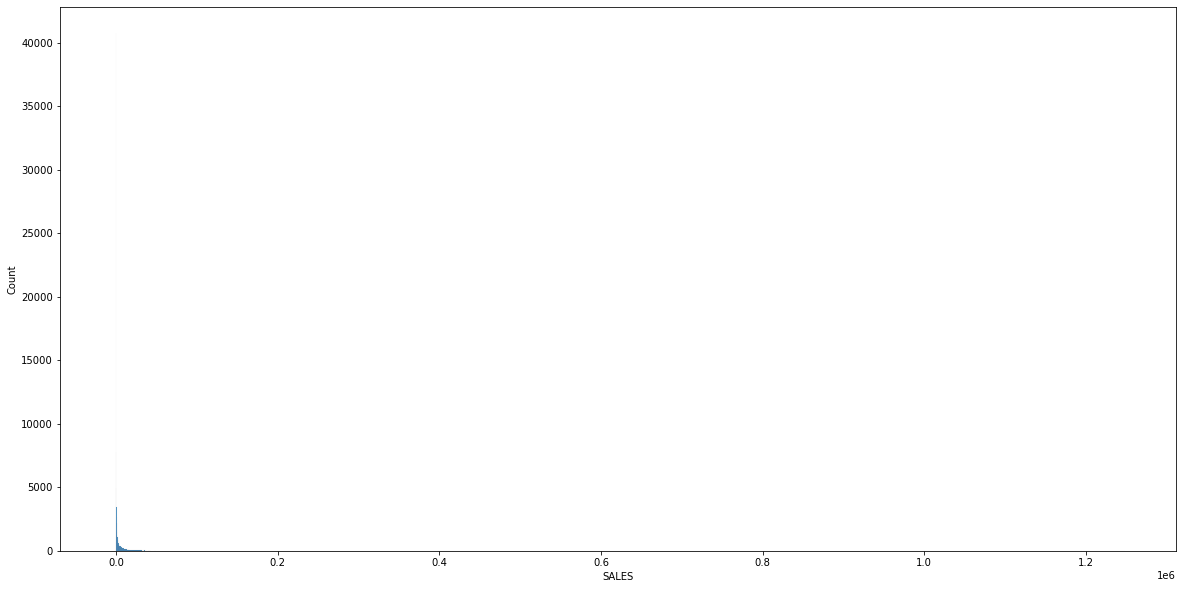

In [36]:
_ = sns.histplot(data['SALES'])

Распределение таргета сильно скошено вправо, т.е. есть товары, которые продаются гораздо чаще других

In [37]:
data.sort_values('SALES', ascending = False).head(50)

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,VOLUME,DATE
20654,2017,6,CROWN IMPORTS,23445,CORONA EXTRA LOOSE NR - 12OZ,BEER,1249000.0,13723.71,354.8820,2017-06-01
32121,2017,6,CROWN IMPORTS,96741,CORONA EXTRA 4/6 NR - 12OZ,BEER,1138360.0,7210.92,354.8820,2017-06-01
69105,2017,10,FIFTH GENERATION INC,53929,TITO'S HANDMADE VODKA - 1.75L,LIQUOR,1101390.0,19.00,1750.0000,2017-10-01
28437,2017,6,FIFTH GENERATION INC,53929,TITO'S HANDMADE VODKA - 1.75L,LIQUOR,1080890.0,15.00,1750.0000,2017-06-01
55459,2017,9,FIFTH GENERATION INC,53929,TITO'S HANDMADE VODKA - 1.75L,LIQUOR,1065280.0,15.00,1750.0000,2017-09-01
47872,2017,9,CROWN IMPORTS,23445,CORONA EXTRA LOOSE NR - 12OZ,BEER,1063000.0,12733.83,354.8820,2017-09-01
18529,2017,5,CROWN IMPORTS,96741,CORONA EXTRA 4/6 NR - 12OZ,BEER,1037370.0,7283.96,354.8820,2017-05-01
74904,2017,11,CROWN IMPORTS,23445,CORONA EXTRA LOOSE NR - 12OZ,BEER,992000.0,16079.12,354.8820,2017-11-01
34308,2017,8,CROWN IMPORTS,23445,CORONA EXTRA LOOSE NR - 12OZ,BEER,990000.0,15346.71,354.8820,2017-08-01
124541,2018,2,FIFTH GENERATION INC,53929,TITO'S HANDMADE VODKA - 1.75L,LIQUOR,983020.0,18.00,1750.0000,2018-02-01


Видно, что множество товаров с большими объемами продаж - популярные напидки (Корона, Хайникен, Смирнофф и тд). Такие товары продаются постоянно, поэтому, чтобы модель могла учесть такую взаимосвязь - добавим информацию о предыдущих продажах товара

Посчитаем скользящие статистики продаж по группам и датам.

In [38]:
summed_sales = data.groupby(['DATE', 'ARTICLE_GROUP'], as_index = False)['SALES'].sum()
mean_sales = data.groupby(['DATE', 'ARTICLE_GROUP'], as_index = False)['SALES'].mean()

In [39]:
def rolling_sum_diff(x):
    ''' Подсчет изменения суммарного (по категории) объема продаж в предыдущие 2 месяца
    '''
    x['SALES']
    x['SALES'].rolling(3)
    x['SALES_SUM_DIFF'] = x['SALES'].rolling(3).apply(lambda x: x.iloc[1] - x.iloc[0])
    return x

def rolling_mean_diff(x):
    '''Подсчет изменения среднего (по категории) объема продаж в предыдущие 2 месяца
    '''
    x['SALES']
    x['SALES'].rolling(3)
    x['SALES_MEAN_DIFF'] = x['SALES'].rolling(3).apply(lambda x: x.iloc[1] - x.iloc[0])
    return x

def rolling_total_previous(x):
    '''Нахождение суммарного (по категории) объема продаж в предыдущий период
    '''
    x['SALES']
    x['SALES'].rolling(3)
    x['SALES_TOTAL_PREVIOUS'] = x['SALES'].rolling(3).apply(lambda x: x.iloc[1])
    return x

def rolling_previous(x):
    '''Нахождение объема продаж (по отдельному товару) в предыдущий период
    '''
    x['SALES']
    x['SALES'].rolling(3)
    x['SALES_PREVIOUS'] = x['SALES'].rolling(3).apply(lambda x: x.iloc[1])
    return x

def rolling_diff(x):
    '''Подсчет изменения объема (по отдельному товару) продаж в предыдущие 2 месяца
    '''
    x['SALES']
    x['SALES'].rolling(3)
    x['SALES_DIFF'] = x['SALES'].rolling(3).apply(lambda x: x.iloc[1] - x.iloc[0])
    return x

In [40]:
rolling_sum_diffs = summed_sales.groupby('ARTICLE_GROUP').apply(rolling_sum_diff)
rolling_mean_diffs = mean_sales.groupby('ARTICLE_GROUP').apply(rolling_mean_diff)
rolling_total_previous = summed_sales.groupby('ARTICLE_GROUP').apply(rolling_total_previous)
data = data.groupby('ARTICLE_NAME').apply(rolling_previous)
data_test = data_test.groupby('ARTICLE_NAME').apply(rolling_previous)

In [41]:
statistics = pd.merge(rolling_sum_diffs[['DATE', 'ARTICLE_GROUP', 'SALES_SUM_DIFF']], 
                      rolling_mean_diffs[['DATE', 'ARTICLE_GROUP', 'SALES_MEAN_DIFF']], on = ['DATE', 'ARTICLE_GROUP'])
statistics = pd.merge(rolling_total_previous[['DATE', 'ARTICLE_GROUP', 'SALES_TOTAL_PREVIOUS']], 
                      statistics, 
                      on = ['DATE', 'ARTICLE_GROUP'])

In [42]:
statistics.head()

,DATE,ARTICLE_GROUP,SALES_TOTAL_PREVIOUS,SALES_SUM_DIFF,SALES_MEAN_DIFF
0,2017-05-01,BEER,NaN,NaN,NaN
1,2017-05-01,LIQUOR,NaN,NaN,NaN
2,2017-05-01,WINE,NaN,NaN,NaN
3,2017-06-01,BEER,NaN,NaN,NaN
4,2017-06-01,LIQUOR,NaN,NaN,NaN


In [43]:
statistics = pd.pivot_table(statistics, 
                            index = 'DATE', 
                            columns = 'ARTICLE_GROUP', 
                            values = ['SALES_SUM_DIFF', 'SALES_MEAN_DIFF', 'SALES_TOTAL_PREVIOUS'])

In [44]:
statistics.head()

SALES_MEAN_DIFF                                        \
ARTICLE_GROUP            BEER      LIQUOR  NON-ALCOHOL          REF   
DATE                                                                  
2017-08-01        1375.453187 -199.540430          NaN          NaN   
2017-09-01       -2686.346357 -846.087727  -743.647257 -2212.000000   
2017-10-01        1036.137691  100.043025 -2439.011194  1646.285714   
2017-11-01       -1364.060797 -169.457995  -339.750000 -2294.285714   
2018-01-01        -388.406219  753.295204   260.726027  5755.714286   

                                       SALES_SUM_DIFF                         \
ARTICLE_GROUP STR_SUPPLIES        WINE           BEER     LIQUOR NON-ALCOHOL   
DATE                                                                           
2017-08-01             NaN   50.966748      2840020.0   -88050.0         NaN   
2017-09-01    -1485.769231 -274.829252     -4833130.0 -2849270.0   -117950.0   
2017-10-01     1937.435897  301.430126       822630.0   346280.0    -94170.0   
2017-11-01    -1395.897436  -33.361415     -1268980.0   -40730.0    -51480.0   
2018-01-01     3151.048951  253.697907       757360.0  3033180.0     59560.0   

                                               SALES_TOTAL_PREVIOUS  \
ARTICLE_GROUP      REF STR_SUPPLIES       WINE                 BEER   
DATE                                                                  
2017-08-01         NaN          NaN -1417250.0           27863260.0   
2017-09-01    -11060.0     -11880.0 -2422190.0           23030130.0   
2017-10-01     19340.0      17300.0  2229440.0           23852760.0   
2017-11-01    -16060.0     -10260.0   171870.0           22583780.0   
2018-01-01     40290.0      21680.0  5167160.0           23341140.0   

                                                                         
ARTICLE_GROUP      LIQUOR NON-ALCOHOL      REF STR_SUPPLIES        WINE  
DATE                                                                     
2017-08-01     35035310.0         NaN      NaN          NaN  33129640.0  
2017-09-01     32186040.0   1091280.0  19540.0      77340.0  30707450.0  
2017-10-01     32532320.0    997110.0  38880.0      94640.0  32936890.0  
2017-11-01     32491590.0    945630.0  22820.0      84380.0  33108760.0  
2018-01-01     35524770.0   1005190.0  63110.0     106060.0  38275920.0

In [45]:
statistics = statistics.reset_index()
statistics.columns = [top + '_' + down for top, down in statistics.columns]

In [46]:
statistics.head()

,DATE_,SALES_MEAN_DIFF_BEER,SALES_MEAN_DIFF_LIQUOR,SALES_MEAN_DIFF_NON-ALCOHOL,SALES_MEAN_DIFF_REF,SALES_MEAN_DIFF_STR_SUPPLIES,SALES_MEAN_DIFF_WINE,SALES_SUM_DIFF_BEER,SALES_SUM_DIFF_LIQUOR,SALES_SUM_DIFF_NON-ALCOHOL,SALES_SUM_DIFF_REF,SALES_SUM_DIFF_STR_SUPPLIES,SALES_SUM_DIFF_WINE,SALES_TOTAL_PREVIOUS_BEER,SALES_TOTAL_PREVIOUS_LIQUOR,SALES_TOTAL_PREVIOUS_NON-ALCOHOL,SALES_TOTAL_PREVIOUS_REF,SALES_TOTAL_PREVIOUS_STR_SUPPLIES,SALES_TOTAL_PREVIOUS_WINE
0,2017-08-01,1375.453187,-199.540430,NaN,NaN,NaN,50.966748,2840020.0,-88050.0,NaN,NaN,NaN,-1417250.0,27863260.0,35035310.0,NaN,NaN,NaN,33129640.0
1,2017-09-01,-2686.346357,-846.087727,-743.647257,-2212.000000,-1485.769231,-274.829252,-4833130.0,-2849270.0,-117950.0,-11060.0,-11880.0,-2422190.0,23030130.0,32186040.0,1091280.0,19540.0,77340.0,30707450.0
2,2017-10-01,1036.137691,100.043025,-2439.011194,1646.285714,1937.435897,301.430126,822630.0,346280.0,-94170.0,19340.0,17300.0,2229440.0,23852760.0,32532320.0,997110.0,38880.0,94640.0,32936890.0
3,2017-11-01,-1364.060797,-169.457995,-339.750000,-2294.285714,-1395.897436,-33.361415,-1268980.0,-40730.0,-51480.0,-16060.0,-10260.0,171870.0,22583780.0,32491590.0,945630.0,22820.0,84380.0,33108760.0
4,2018-01-01,-388.406219,753.295204,260.726027,5755.714286,3151.048951,253.697907,757360.0,3033180.0,59560.0,40290.0,21680.0,5167160.0,23341140.0,35524770.0,1005190.0,63110.0,106060.0,38275920.0


In [47]:
data = pd.merge(data, statistics, left_on = 'DATE', right_on = 'DATE_', how = 'inner')

In [48]:
data_test = pd.merge(data_test, statistics, left_on = 'DATE', right_on = 'DATE_', how = 'inner')

Удалим ненужные колонки

In [49]:
data = data.drop(['YEAR', 'MONTH', 'ARTICLE_CODE', 'STORE_SALES', 'DATE_'], axis = 'columns')
data_test = data_test.drop(['YEAR', 'MONTH', 'ARTICLE_CODE', 'STORE_SALES', 'DATE_'], axis = 'columns')

Закодируем колонки для обучения модели

In [50]:
le = LabelEncoder()
data['CONTRAGENT'] = data['CONTRAGENT'].fillna('missed')
data_test['CONTRAGENT'] = data_test['CONTRAGENT'].fillna('missed')
le.fit(data['CONTRAGENT'])
data['CONTRAGENT'] = le.transform(data['CONTRAGENT'])
data_test['CONTRAGENT'] = le.transform(data_test['CONTRAGENT'])

le = LabelEncoder()
data['ARTICLE_GROUP'] = data['ARTICLE_GROUP'].fillna('missed')
data_test['ARTICLE_GROUP'] = data_test['ARTICLE_GROUP'].fillna('missed')
le.fit(data['ARTICLE_GROUP'])
data['ARTICLE_GROUP'] = le.transform(data['ARTICLE_GROUP'])
def test_encoding(x, le = le):
    if x not in ['KEGS', 'DUNNAGE']:
        return le.transform([x])[0]
    else:
        return x
data_test['ARTICLE_GROUP'] = data_test['ARTICLE_GROUP'].apply(test_encoding)

Финальный датасет

In [51]:
data = data.reset_index(drop = True)

In [52]:
data.head()

,CONTRAGENT,ARTICLE_NAME,ARTICLE_GROUP,SALES,VOLUME,DATE,SALES_PREVIOUS,SALES_MEAN_DIFF_BEER,SALES_MEAN_DIFF_LIQUOR,SALES_MEAN_DIFF_NON-ALCOHOL,...,SALES_SUM_DIFF_NON-ALCOHOL,SALES_SUM_DIFF_REF,SALES_SUM_DIFF_STR_SUPPLIES,SALES_SUM_DIFF_WINE,SALES_TOTAL_PREVIOUS_BEER,SALES_TOTAL_PREVIOUS_LIQUOR,SALES_TOTAL_PREVIOUS_NON-ALCOHOL,SALES_TOTAL_PREVIOUS_REF,SALES_TOTAL_PREVIOUS_STR_SUPPLIES,SALES_TOTAL_PREVIOUS_WINE
0,90,TWO BOTTLE WINE TOTE,4,100.0,NaN,2017-08-01,NaN,1375.453187,-199.54043,NaN,...,NaN,NaN,NaN,-1417250.0,27863260.0,35035310.0,NaN,NaN,NaN,33129640.0
1,138,PAPI P/GRIG - 750ML,5,0.0,750.00000,2017-08-01,0.0,1375.453187,-199.54043,NaN,...,NaN,NaN,NaN,-1417250.0,27863260.0,35035310.0,NaN,NaN,NaN,33129640.0
2,228,KEDEM CREAM RED CONCORD - 750ML,5,0.0,750.00000,2017-08-01,NaN,1375.453187,-199.54043,NaN,...,NaN,NaN,NaN,-1417250.0,27863260.0,35035310.0,NaN,NaN,NaN,33129640.0
3,219,SAM SMITH ORGANIC PEAR CIDER - 18.7OZ,0,0.0,553.02445,2017-08-01,NaN,1375.453187,-199.54043,NaN,...,NaN,NaN,NaN,-1417250.0,27863260.0,35035310.0,NaN,NaN,NaN,33129640.0
4,219,TRAQUAIR JACOBITE ALE - 16.9OZ,0,0.0,499.79215,2017-08-01,NaN,1375.453187,-199.54043,NaN,...,NaN,NaN,NaN,-1417250.0,27863260.0,35035310.0,NaN,NaN,NaN,33129640.0


# Валидация

Будем проводить time series cross validation\
В качестве валидационных дат возьмем 2017.10 и 2017.11. На этих месяцах будем проводить валидацию и подбирать параметры. В качестве тестового месяца будем использовать 2018.01 (необходимо чтобы на тточность модели на этом месяце была такая же, как и на валидационных месяцах).

In [53]:
# Получение индексов кросс валидации
cv_list = cv.get_indices_ts(data, splits = (('2017-10-01', '2017-11-01'), 
                                            ('2017-11-01', '2017-12-01'), 
                                            ('2018-01-01', '2018-02-01')),
                            date_col = 'DATE')

In [54]:
X = data.drop(['SALES', 'DATE', 'ARTICLE_NAME'], axis = 'columns')
y = data['SALES']

In [55]:
X.columns

Index(['CONTRAGENT', 'ARTICLE_GROUP', 'VOLUME', 'SALES_PREVIOUS',
       'SALES_MEAN_DIFF_BEER', 'SALES_MEAN_DIFF_LIQUOR',
       'SALES_MEAN_DIFF_NON-ALCOHOL', 'SALES_MEAN_DIFF_REF',
       'SALES_MEAN_DIFF_STR_SUPPLIES', 'SALES_MEAN_DIFF_WINE',
       'SALES_SUM_DIFF_BEER', 'SALES_SUM_DIFF_LIQUOR',
       'SALES_SUM_DIFF_NON-ALCOHOL', 'SALES_SUM_DIFF_REF',
       'SALES_SUM_DIFF_STR_SUPPLIES', 'SALES_SUM_DIFF_WINE',
       'SALES_TOTAL_PREVIOUS_BEER', 'SALES_TOTAL_PREVIOUS_LIQUOR',
       'SALES_TOTAL_PREVIOUS_NON-ALCOHOL', 'SALES_TOTAL_PREVIOUS_REF',
       'SALES_TOTAL_PREVIOUS_STR_SUPPLIES', 'SALES_TOTAL_PREVIOUS_WINE'],
      dtype='object')

# Подбор модели

Не понятно, что надо делать с предложенной метрикой

In [56]:
def metric_suggested(y_true, y_pred):
    
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

Если надо максимизировать - просто делаем предсказания 0 и делением на ноль метрика улетает в +inf.\
Если надо минимизировать - предсказываем -inf и получаем делением положительного числа на сумму отрицательных предсказаний сколь угодно маленькое значение

Поэтому буду использовать MAE метрику для оценки предсказаний

In [57]:
def metric(y_true, y_pred):
    
    return np.mean(np.abs(y_true-y_pred))

In [59]:
%%capture
def params_func(trial, X):
    return(
        {
            # Метрика, которую будет минимизировать модель (использование другой функции потерь может помочь преодолеть 
            # локальные минимумы во время градиентного спуска)
            'objective': trial.suggest_categorical('objective', ['huber', 'fair', 'l2', 'l1', 'mape']), 
            # Метрика, которую будем минимизировать при подборе параметров
            'validation_loss': metric,
            'n_jobs': -1,
            # Максимальное кол-во итераций градиентного бустинга в lgbm
            'n_estimators': 1500,
            'early_stopping_rounds': 10,
            'random_state': random_state,
            # Категориальные фичи
            'categorical_feature': ['ARTICLE_GROUP'],
            'feature_name': ['ARTICLE_GROUP', 'VOLUME', 'SALES_PREVIOUS',
       'SALES_MEAN_DIFF_BEER', 'SALES_MEAN_DIFF_LIQUOR',
       'SALES_MEAN_DIFF_NON-ALCOHOL', 'SALES_MEAN_DIFF_REF',
       'SALES_MEAN_DIFF_STR_SUPPLIES', 'SALES_MEAN_DIFF_WINE',
       'SALES_SUM_DIFF_BEER', 'SALES_SUM_DIFF_LIQUOR',
       'SALES_SUM_DIFF_NON-ALCOHOL', 'SALES_SUM_DIFF_REF',
       'SALES_SUM_DIFF_STR_SUPPLIES', 'SALES_SUM_DIFF_WINE',
       'SALES_TOTAL_PREVIOUS_BEER', 'SALES_TOTAL_PREVIOUS_LIQUOR',
       'SALES_TOTAL_PREVIOUS_NON-ALCOHOL', 'SALES_TOTAL_PREVIOUS_REF',
       'SALES_TOTAL_PREVIOUS_STR_SUPPLIES', 'SALES_TOTAL_PREVIOUS_WINE'],
            # На какой подвыборке будет обучаться каждое дерево
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.01, 1),
            # На какой подвыборке фичей будет обучаться каждое дерево
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.01, 1),
            # Минимальное количество наблюдений в листах деревьев (ставим много, т.к. переобучение будет контролировать
            # количеством листов)
            'min_child_samples': 10**1000,
            # Максимальное количество листов в каждом дереве
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.5)
        }
    )

# Инициализируем класс, подбирающий параметры
# n_trials - сколько будет попыток при выборе параметров, оптимизирующих метрику
# optuna.samplers.TPESampler сэмплировать параметры будем с помощью tree parzen estimator
my_training = model_selection.training(direction = 'minimize', model = 'lgbm',
                                       params_func = params_func, n_trials = 50,
                                       random_state = random_state, sampler = optuna.samplers.TPESampler)
# Инициализируем эксперимент на neptune.ai
my_training.initiate_neptune_exp(name = 'LGBM', 
                                 description = 
                                "['ARTICLE_GROUP', 'VOLUME', 'SALES_MEAN_DIFF_BEER',\
       'SALES_MEAN_DIFF_LIQUOR', 'SALES_MEAN_DIFF_NON-ALCOHOL',\
       'SALES_MEAN_DIFF_REF', 'SALES_MEAN_DIFF_STR_SUPPLIES',\
       'SALES_MEAN_DIFF_WINE', 'SALES_PREVIOUS_BEER', 'SALES_PREVIOUS_LIQUOR',\
       'SALES_PREVIOUS_NON-ALCOHOL', 'SALES_PREVIOUS_REF',\
       'SALES_PREVIOUS_STR_SUPPLIES', 'SALES_PREVIOUS_WINE',\
       'SALES_SUM_DIFF_BEER', 'SALES_SUM_DIFF_LIQUOR',\
       'SALES_SUM_DIFF_NON-ALCOHOL', 'SALES_SUM_DIFF_REF',\
       'SALES_SUM_DIFF_STR_SUPPLIES', 'SALES_SUM_DIFF_WINE'] + все товары (без удаления товаров с нулевыми продажами)"
                                )

# Находим оптимальные параметры
my_training.train(X = X.drop(['CONTRAGENT'], axis = 'columns'), 
                  y = y, 
                  cv = cv_list)

[I 2021-05-24 16:35:05,600] A new study created in memory with name: no-name-a19de820-b52f-425d-9240-26026ca3b1e3
[I 2021-05-24 16:35:18,584] Trial 0 finished with value: 9178.034728979905 and parameters: {'objective': 'huber', 'bagging_fraction': 0.41932369587670204, 'feature_fraction': 0.09478431502162439, 'num_leaves': 200, 'learning_rate': 0.7385350278441493}. Best is trial 0 with value: 9178.034728979905.
[I 2021-05-24 16:35:19,577] Trial 1 finished with value: 6877.50140765343 and parameters: {'objective': 'mape', 'bagging_fraction': 0.6423226710562105, 'feature_fraction': 0.9464009904010453, 'num_leaves': 189, 'learning_rate': 1.2348640102604613}. Best is trial 1 with value: 6877.50140765343.
[I 2021-05-24 16:35:19,920] Trial 2 finished with value: 3270.3804277878544 and parameters: {'objective': 'l2', 'bagging_fraction': 0.8076200381886964, 'feature_fraction': 0.915333983419317, 'num_leaves': 39, 'learning_rate': 1.4375702496048037}. Best is trial 2 with value: 3270.38042778785

[I 2021-05-24 16:36:05,523] Trial 26 finished with value: 9627.342102383005 and parameters: {'objective': 'huber', 'bagging_fraction': 0.1976703033578625, 'feature_fraction': 0.3254860489494671, 'num_leaves': 18, 'learning_rate': 0.012949747335042505}. Best is trial 3 with value: 2327.8661517400055.
[I 2021-05-24 16:36:06,295] Trial 27 finished with value: 2562.277275489809 and parameters: {'objective': 'l1', 'bagging_fraction': 0.014385517673452586, 'feature_fraction': 0.2129326251657615, 'num_leaves': 41, 'learning_rate': 0.12198505975604253}. Best is trial 3 with value: 2327.8661517400055.
[I 2021-05-24 16:36:08,082] Trial 28 finished with value: 2400.8124645870475 and parameters: {'objective': 'l1', 'bagging_fraction': 0.6274797680098878, 'feature_fraction': 0.5679961271352405, 'num_leaves': 11, 'learning_rate': 0.2434176759528432}. Best is trial 3 with value: 2327.8661517400055.
[I 2021-05-24 16:36:16,239] Trial 29 finished with value: 9316.112323679166 and parameters: {'objective

# Результаты:

In [60]:
pd.read_csv('results.csv')

,Id,logs/best_so_far_run_score (last),Description,Name,logs/metric_std_cv (min),logs/metric_test (min)
0,MAG-49,2319.033173,"['ARTICLE_GROUP', 'VOLUME', 'SALES_MEAN_DIFF_B...",LGBM,2613.038114,21.775693
1,MAG-48,33993.913230,"['CONTRAGENT', 'ARTICLE_GROUP', 'VOLUME', 'SAL...",SVR,32823.809672,443.293106
2,MAG-46,2662.299504,"['CONTRAGENT', 'ARTICLE_GROUP', 'VOLUME', 'SAL...",Ridge,6442.388755,322.500074
3,MAG-34,2323.507791,"['CONTRAGENT', 'ARTICLE_GROUP', 'VOLUME', 'SAL...",LGBM,2648.667190,21.763338
4,MAG-31,3237.774761,"['CONTRAGENT', 'ARTICLE_GROUP', 'VOLUME', 'SAL...",LGBM,3842.815863,73.677174


Mag-34. LGBM. Обучение на всех колонках со всеми данными (без удаления товаров с постоянно нулевыми продажами)\
Mag-49. LGBM. Обучение без CONTRAGENT (была гипотеза, что модель переобучается из за нее) со всеми данными (без удаления товаров с постоянно нулевыми продажами)\
Mag-31. LGBM. Обучение на всех колонках только с товарами, у которых есть ненулевые продажи
MAG-46. Ridge регрессия на всех данных. 
MAG-48. Supported vector regression на всех данных.

Дроп CONTRAGENT не повлиял на результаты модели.\
При дропе товаров с нулевыми продажами результат модели ухудшился (но при дропе товаров с нулевыми родажами эти товары дропнулись и из тестовой части. Поправка на удаление этих нулевых товаров показала, что результат модели примерно соотвествует результату модели, обученной на всех данных). \
SVR и ridge regression выдают сильно нестабильные предсказания (большое стандартное отклонение метрики)

В среднем на валидационных фолдах (первые два фолда в cv_list) модель ошибается на 2300\
При этом стандартное отклонение между фолдами достаточно большое (~3000), то есть модель показывает разные результьаты на двух разных фолдах.\
На тестовой части (она не использовалась ни при обучении модели, ни при подборе параметров) модель ошибается на ~250, что можно назвать приличным результатов (среднее таргета 6580, предсказание средним дает значение метрики ~9200)

Обучим модель (MAG-49) на подобранных параметрах

In [61]:
params = {'objective': 'l1',
          'n_jobs': -1, 
          'n_estimators': 27, 
          'random_state': 54321, 
          'bagging_fraction': 0.8530565791464408, 
          'feature_fraction': 0.9918382331744173, 
          'min_child_samples': 10**100,
          'num_leaves': 44, 
          'learning_rate': 0.32846232631810607}

In [62]:
categorical_feature = ['ARTICLE_GROUP'] 
feature_name = ['ARTICLE_GROUP', 'VOLUME', 'SALES_PREVIOUS', 
                'SALES_MEAN_DIFF_BEER', 'SALES_MEAN_DIFF_LIQUOR', 
                'SALES_MEAN_DIFF_NON-ALCOHOL', 'SALES_MEAN_DIFF_REF', 
                'SALES_MEAN_DIFF_STR_SUPPLIES', 'SALES_MEAN_DIFF_WINE', 
                'SALES_SUM_DIFF_BEER', 'SALES_SUM_DIFF_LIQUOR', 'SALES_SUM_DIFF_NON-ALCOHOL', 
                'SALES_SUM_DIFF_REF', 'SALES_SUM_DIFF_STR_SUPPLIES', 'SALES_SUM_DIFF_WINE', 
                'SALES_TOTAL_PREVIOUS_BEER', 'SALES_TOTAL_PREVIOUS_LIQUOR', 'SALES_TOTAL_PREVIOUS_NON-ALCOHOL',
                'SALES_TOTAL_PREVIOUS_REF', 'SALES_TOTAL_PREVIOUS_STR_SUPPLIES', 'SALES_TOTAL_PREVIOUS_WINE']

Обучаем на всех данных, кроме последнего месяца

In [63]:
train_data = lgb.Dataset(data[data['DATE']!= '2018-02-01'].drop(['DATE', 'SALES', 'CONTRAGENT', 'ARTICLE_NAME'], axis = 'columns'),
                         data[data['DATE']!= '2018-02-01']['SALES'], 
                         feature_name = feature_name, 
                         categorical_feature = categorical_feature)

In [64]:
model = lgb.train(params = params,
                  train_set = train_data,
                  verbose_eval = False)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 451
[LightGBM] [Info] Number of data points in the train set: 66145, number of used features: 21
[LightGBM] [Info] Start training from score 410.000000


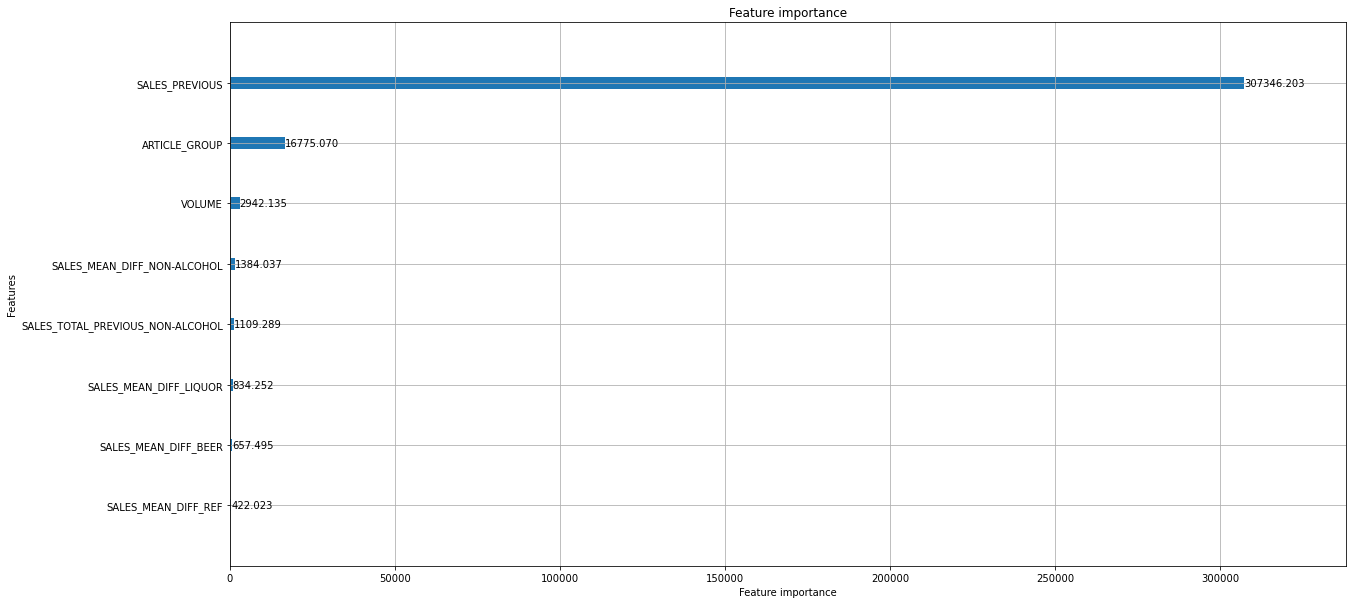

In [65]:
_ = lgb.plot_importance(model, importance_type = 'gain')

Самой полезной фичой как и ожидалось оказалась информация о продажах товара в предыдущий месяц\
Информация о группе товаров также ожидаемо оказалась полезной\
Не зря извлекли информацию об объеме, она тоже немного докинула\
Остальные фичи гораздо менее полезные

Делаем предсказания для последнего месяца (а там, где ['ARTICLE_GROUP'].isin(['DUNNAGE', 'KEGS'] предсказываем 0)

In [66]:
data_test = data_test.reset_index(drop = True)

In [67]:
test_predictions = data[data['DATE']== '2018-02-01']
test_predictions['ARTICLE_GROUP'] = test_predictions['ARTICLE_GROUP'].astype(float)

In [68]:
predictions = model.predict(test_predictions.drop(['DATE', 'SALES', 'ARTICLE_NAME', 'CONTRAGENT'], axis = 'columns'))
test_predictions['predictions'] = predictions

In [ ]:
data_test['predictions'] = None

In [ ]:
data_test = data_test[data_test['ARTICLE_GROUP'].isin(['DUNNAGE', 'KEGS'])].append(test_predictions)

In [ ]:
data_test['predictions'] = data_test['predictions'].fillna(0)

Значение MAE

In [ ]:
metric(data_test['SALES'], data_test['predictions'])

Значение предложенной метрики

In [ ]:
metric_suggested(data_test['SALES'], data_test['predictions'])

In [ ]:
_ = sns.histplot(data_test['SALES']-data_test['predictions'])

В среднем ошибка модель ошибается несильно, но при этом для некоторых товаров предсказания сильно отличаются от реальности\
Это все те же популярные товары с большими объемами продаж

In [ ]:
data_test['error'] = (data_test['SALES']-data_test['predictions'])

In [ ]:
data_test.sort_values('error', ascending = False)